## Import Libraries

In [1]:
pip install -r "../../requirements.txt"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import pickle

sns.set(style= "whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))
%matplotlib inline

## SF raw listing 

In [3]:
listing_df = pd.read_csv("../../May Myo/raw_data/listings.csv.gz")
listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

### Filter variables we want

In [4]:
df= listing_df[['id','neighbourhood_cleansed','amenities','accommodates']]
df

,id,neighbourhood_cleansed,amenities,accommodates
0,958,Western Addition,"[""Heating"", ""Hot water"", ""Stove"", ""Iron"", ""Dry...",3
1,5858,Bernal Heights,"[""Smoke alarm"", ""Heating"", ""Kitchen"", ""First a...",5
2,7918,Haight Ashbury,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",2
3,8142,Haight Ashbury,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",2
4,8339,Western Addition,"[""Heating"", ""Hot water"", ""Stove"", ""Iron"", ""Car...",4
...,...,...,...,...
7269,44758668,Mission,"[""Smoke alarm"", ""Long term stays allowed"", ""Re...",2
7270,44799193,Downtown/Civic Center,"[""Smoke alarm"", ""Long term stays allowed"", ""Re...",2
7271,44805385,Lakeshore,"[""Gym"", ""Heating"", ""Air conditioning"", ""Iron"",...",6
7272,44810526,South of Market,"[""Gym"", ""Heating"", ""Hot water"", ""Stove"", ""Air ...",1


### Get unique amentities

In [5]:
amentities_col = df.amenities
amentities_dict = {}
id = 0
for amentities in amentities_col:
    x_striped = amentities[1:-1]
    x_arr = x_striped.split(',')
    
    for amentity in x_arr:
        name = "{}".format((amentity.strip())[1:-1].lower().replace("\\u2019","'"))
        
        if name not in amentities_dict:
            amentities_dict[name] = 1
        else:
            amentities_dict[name] += 1
sorted_amentities = dict(sorted(amentities_dict.items(), key=lambda x: x[1], reverse=True))
sorted_amentities = {k: v for k, v in sorted_amentities.items() if v >= 30}
filter_amentities = list(sorted_amentities.keys())
filter_amentities

['wifi',
 'smoke alarm',
 'heating',
 'essentials',
 'hangers',
 'carbon monoxide alarm',
 'hair dryer',
 'iron',
 'tv',
 'shampoo',
 'kitchen',
 'laptop-friendly workspace',
 'washer',
 'dryer',
 'fire extinguisher',
 'hot water',
 'refrigerator',
 'coffee maker',
 'microwave',
 'dishes and silverware',
 'first aid kit',
 'bed linens',
 'oven',
 'free street parking',
 'cooking basics',
 'private entrance',
 'stove',
 'dishwasher',
 'cable tv',
 'extra pillows and blankets',
 'long term stays allowed',
 'luggage dropoff allowed',
 'garden or backyard',
 'patio or balcony',
 'lock on bedroom door',
 'lockbox',
 'elevator',
 'free parking on premises',
 'bathtub',
 'indoor fireplace',
 'air conditioning',
 'keypad',
 'gym',
 'paid parking off premises',
 'bbq grill',
 'breakfast',
 "pack 'n play/travel crib",
 'host greets you',
 'paid parking on premises',
 'shower gel',
 'room-darkening shades',
 "children's books and toys",
 'building staff',
 'single level home',
 'ethernet connecti

### Manually create encoding columns

In [6]:
for item in filter_amentities:
    df[item] = 0
df

<ipython-input-6-3bf887f684b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[item] = 0


,id,neighbourhood_cleansed,amenities,accommodates,wifi,smoke alarm,heating,essentials,hangers,carbon monoxide alarm,...,baby bath,pocket wifi,changing table,window guards,beach essentials,ev charger,beachfront,table corner guards,bread maker,waterfront
0,958,Western Addition,"[""Heating"", ""Hot water"", ""Stove"", ""Iron"", ""Dry...",3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5858,Bernal Heights,"[""Smoke alarm"", ""Heating"", ""Kitchen"", ""First a...",5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7918,Haight Ashbury,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8142,Haight Ashbury,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8339,Western Addition,"[""Heating"", ""Hot water"", ""Stove"", ""Iron"", ""Car...",4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7269,44758668,Mission,"[""Smoke alarm"", ""Long term stays allowed"", ""Re...",2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7270,44799193,Downtown/Civic Center,"[""Smoke alarm"", ""Long term stays allowed"", ""Re...",2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7271,44805385,Lakeshore,"[""Gym"", ""Heating"", ""Air conditioning"", ""Iron"",...",6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7272,44810526,South of Market,"[""Gym"", ""Heating"", ""Hot water"", ""Stove"", ""Air ...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Manual one hot encoding

In [7]:
for index, rows in df.iterrows():
    tmp = rows['amenities']
    tmp = (tmp.strip())[1:-1].lower().replace("\\u2019","'").split(",")
    for item in tmp:
        item = item.replace('"', "").strip()
        if item in filter_amentities:
            df.loc[index, item] = 1

### store encoding columns with ID into pickle

In [8]:
Filepath = "encoded_amentities.pkl"

if os.path.exists(Filepath):
    encoded_Df = pd.read_pickle(Filepath)
    print("read success!")
else:
    filter_amentities.insert(0,"id")
    encoded_Df = df[[x for x in filter_amentities]]
    encoded_Df.to_pickle("encoded_amentities.pkl")

read success!


## Merge listing and safe index score

In [9]:
safe_df = pd.read_pickle("safeIndex.pkl")
safe_df

,Area,Category,Score
0,Bayview,overall,51.8
1,Bayview,lgbtq,46.0
2,Bayview,medical,76.6
3,Bayview,physicalHarm,46.4
4,Bayview,politicalFreedom,31.4
...,...,...,...
233,Western Addition,medical,72.0
234,Western Addition,physicalHarm,32.0
235,Western Addition,politicalFreedom,23.0
236,Western Addition,theft,55.0


### Merge safe df with listing_df_filtered

In [10]:
df = df.drop('amenities', 1)
df = pd.merge(left=df, right=safe_df, left_on='neighbourhood_cleansed', right_on='Area').drop(columns=['Area'])
df.reset_index(drop=True, inplace=True)
df

,id,neighbourhood_cleansed,accommodates,wifi,smoke alarm,heating,essentials,hangers,carbon monoxide alarm,hair dryer,...,changing table,window guards,beach essentials,ev charger,beachfront,table corner guards,bread maker,waterfront,Category,Score
0,958,Western Addition,3,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,overall,40.0
1,958,Western Addition,3,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,lgbtq,33.0
2,958,Western Addition,3,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,medical,72.0
3,958,Western Addition,3,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,physicalHarm,32.0
4,958,Western Addition,3,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,politicalFreedom,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50878,44520574,Visitacion Valley,4,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,medical,75.8
50879,44520574,Visitacion Valley,4,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,physicalHarm,47.6
50880,44520574,Visitacion Valley,4,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,politicalFreedom,31.0
50881,44520574,Visitacion Valley,4,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,theft,70.8


## Get sentiment score

In [11]:
df_sentiment = pd.read_pickle("../../Tanny/df_sentiment.pkl")
df_sentiment

,listing_id,id,comments,comments_cleansed,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,958,5977,"Our experience was, without a doubt, a five st...",experi without doubt five star experi holli hu...,0.000,0.788,0.212,0.9590
1,958,6660,Returning to San Francisco is a rejuvenating t...,return francisco rejuven thrill time enhanc st...,0.000,0.697,0.303,0.9819
2,958,11519,We were very pleased with the accommodations a...,pleas accommod friendli neighborhood be abl ma...,0.134,0.710,0.156,0.7600
3,958,16282,We highly recommend this accomodation and agre...,highli recommend accomod agre previou post hol...,0.035,0.646,0.319,0.9840
4,958,26008,Holly's place was great. It was exactly what I...,holli place great exactli need perfect locat s...,0.000,0.613,0.387,0.9617
...,...,...,...,...,...,...,...,...
320623,44554195,649112168,"Cute, updated hotel in a very central area. Ea...",cute updat hotel central area easi check frien...,0.000,0.434,0.566,0.9398
320624,44554195,649140249,Skip this air bnb. To many cons . you won't en...,skip mani con enjoy stay,0.168,0.832,0.000,-0.3875
320625,44554195,649170022,A fantastic stay! Thank you!,fantast stay thank,0.000,0.230,0.770,0.7707
320626,44554195,649218478,This place is not good as it seems. Lack of co...,thi place good seem lack commun took hour find...,0.166,0.834,0.000,-0.7765


### Generate sentiment label

In [12]:
def label_sentiment (df, threshold = 0.8):
    if df['sentiment_compound'] >= threshold :
        return 1
    return 0
df_sentiment['sentiment_label'] = df_sentiment.apply(label_sentiment, axis=1)

In [13]:
final_sentiment = df_sentiment[['listing_id', 'sentiment_label']]
final_sentiment

,listing_id,sentiment_label
0,958,1
1,958,1
2,958,0
3,958,1
4,958,1
...,...,...
320623,44554195,1
320624,44554195,0
320625,44554195,0
320626,44554195,0


## Selection of train and test data

In [14]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV
import eli5
from eli5.sklearn import PermutationImportance

C:\Users\lingx\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\lingx\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
Filepath = "amentities_safe_df.pkl"

if os.path.exists(Filepath):
    final_df = pd.read_pickle(Filepath)
    print("read success!")
else:
    final_df= pd.merge(left=df, right=final_sentiment, left_on='id', right_on='listing_id').drop(columns=['listing_id'])
    final_df.reset_index(drop=True, inplace=True)
    final_df.to_pickle(Filepath)

category = "overall"
final_df = final_df[final_df['Category'] ==category]

columnDrop = ["id","Category", "neighbourhood_cleansed"]
final_df.drop(columns=columnDrop,inplace=True)
final_df.reset_index(drop=True, inplace=True)

read success!


### Check missing value

In [16]:
for c in final_df.columns:
    no_missing = final_df[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)
    else:
        print(c)
        print("No missing values")
        print(' ')

accommodates
No missing values
 
wifi
No missing values
 
smoke alarm
No missing values
 
heating
No missing values
 
essentials
No missing values
 
hangers
No missing values
 
carbon monoxide alarm
No missing values
 
hair dryer
No missing values
 
iron
No missing values
 
tv
No missing values
 
shampoo
No missing values
 
kitchen
No missing values
 
laptop-friendly workspace
No missing values
 
washer
No missing values
 
dryer
No missing values
 
fire extinguisher
No missing values
 
hot water
No missing values
 
refrigerator
No missing values
 
coffee maker
No missing values
 
microwave
No missing values
 
dishes and silverware
No missing values
 
first aid kit
No missing values
 
bed linens
No missing values
 
oven
No missing values
 
free street parking
No missing values
 
cooking basics
No missing values
 
private entrance
No missing values
 
stove
No missing values
 
dishwasher
No missing values
 
cable tv
No missing values
 
extra pillows and blankets
No missing values
 
long t

In [17]:
k = final_df['sentiment_label'].sum()
k

280610

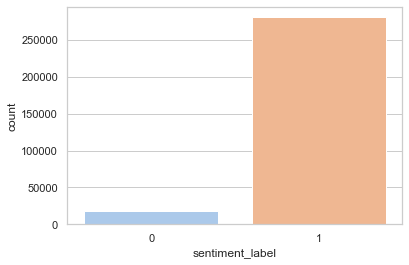

In [18]:
sns.countplot(final_df['sentiment_label'],label="Sum")
plt.show()

### Data Spliting

In [19]:
from sklearn.model_selection import train_test_split
import copy 

sample_result = {"Model":[],"Accuracy":[], 'F1-score':[],'Recall':[] }

def train_test(X, Y, test_size = 0.33, random_state = 42):
    '''
    Splitting the dataset into the Training set and Test set
    '''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size=test_size, random_state=random_state)
    
    return X_train, X_test, Y_train, Y_test

def sampleRun(model,X_test, y_test, df, name):
    pred = model.predict(X_test)
    df['Model'].append(name)
    df['Accuracy'].append(accuracy_score(y_test, pred))
    df['F1-score'].append(f1_score(y_test, pred))
    df['Recall'].append(recall_score(y_test, pred))
    
    return df

In [20]:
final_df2 = copy.deepcopy(final_df)

y = final_df2.pop('sentiment_label')
X = final_df2
X_train, X_test, y_train, y_test = train_test(X,y)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
negative = X[X.sentiment_label==0]
positive = X[X.sentiment_label==1]

### Resampling Techniques — Oversample minority class

1    188026
0    188026
Name: sentiment_label, dtype: int64


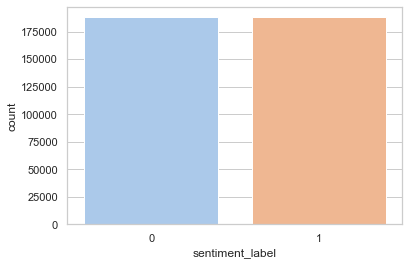

In [21]:
from sklearn.utils import resample

# upsample minority
sentiment_upsampled = resample(negative,
                          replace=True, # sample with replacement
                          n_samples=len(positive), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([positive, sentiment_upsampled])

# check new class counts
print(upsampled.sentiment_label.value_counts())

sns.countplot(upsampled.sentiment_label,label="Sum")
plt.show()

In [22]:
y_train_oversample = upsampled.sentiment_label
X_train_oversample  = upsampled.drop('sentiment_label', axis=1)

LR_model = LogisticRegression(solver='liblinear').fit(X_train_oversample , y_train_oversample)

sample_result = sampleRun(LR_model,X_test,y_test,sample_result,"Oversample")

### Resampling techniques — Undersample majority class

1    11615
0    11615
Name: sentiment_label, dtype: int64


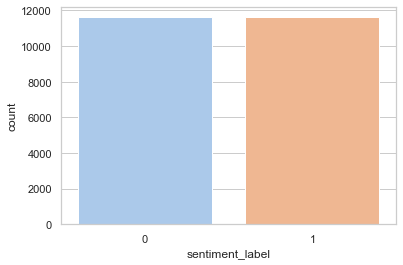

In [23]:
sentiment_downsampled = resample(positive,
                                replace = False, # sample without replacement
                                n_samples = len(negative), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([sentiment_downsampled, negative])

# checking counts
print(downsampled.sentiment_label.value_counts())

sns.countplot(downsampled.sentiment_label,label="Sum")
plt.show()

In [24]:
y_train_downsampled = downsampled.sentiment_label
X_train_downsampled = downsampled.drop('sentiment_label', axis=1)
LR_model = LogisticRegression(solver='liblinear').fit(X_train_downsampled, y_train_downsampled)

sample_result = sampleRun(LR_model,X_test,y_test,sample_result,"Undersample")

### Generate synthetic samples
A technique similar to upsampling is to create synthetic samples. Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

In [25]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27)
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

In [26]:
LR_model = LogisticRegression(solver='liblinear').fit(X_train_smote, y_train_smote)
sample_result = sampleRun(LR_model,X_test,y_test,sample_result,"Smote")

### Resampling results

In [27]:
pd.DataFrame.from_dict(sample_result)

,Model,Accuracy,F1-score,Recall
0,Oversample,0.637859,0.769795,0.643081
1,Undersample,0.628870,0.762653,0.633284
2,Smote,0.624181,0.759130,0.628986


## Features selection

In [28]:
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

### Merging train_oversample and test set for features selection

In [29]:
X_final = X_train_oversample.append(X_test)
X_final

,accommodates,wifi,smoke alarm,heating,essentials,hangers,carbon monoxide alarm,hair dryer,iron,tv,...,pocket wifi,changing table,window guards,beach essentials,ev charger,beachfront,table corner guards,bread maker,waterfront,Score
26860,3,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,51.0
180041,4,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,40.0
246004,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,48.2
129578,2,1,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,37.8
90040,4,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,48.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199934,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,28.0
81955,2,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,48.2
151450,3,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,48.8
150300,2,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,48.8


In [30]:
y_final = y_train_oversample.append(y_test)
y_final

26860     1
180041    1
246004    1
129578    1
90040     1
         ..
199934    1
81955     1
151450    1
150300    1
294674    1
Name: sentiment_label, Length: 474384, dtype: int64

### Before Removing

In [31]:
feature_selection_df = {'Result':['Accuracy', 'Number of Features']}
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_oversample , y_train_oversample)
print("Accuracy on test data: {}".format(clf.score(X_test, y_test)))

feature_selection_df['before feature extraction'] = [clf.score(X_test, y_test), len(X_train_oversample.columns)]

Accuracy on test data: 0.654354635317089


In [32]:
labelling = X_final.columns
labelling = labelling.to_numpy()

In [33]:
Filepath = "permutation_importance.pickle"
if os.path.exists(Filepath):
    with open(Filepath, 'rb') as f:
        result = pickle.load(f)
        print("read success!")
else:
    result = permutation_importance(clf, 
                                    X_train_oversample, 
                                    y_train_oversample, 
                                    n_repeats=10,
                                    random_state=42)
    with open(Filepath, 'wb') as f:
        pickle.dump(result, f, pickle.HIGHEST_PROTOCOL)

read success!


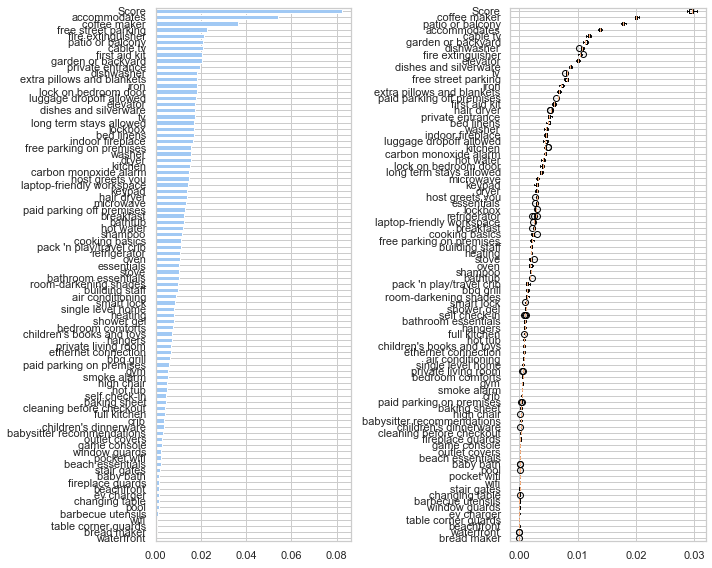

In [34]:
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(labelling[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=labelling[perm_sorted_idx])
fig.tight_layout()
plt.show()

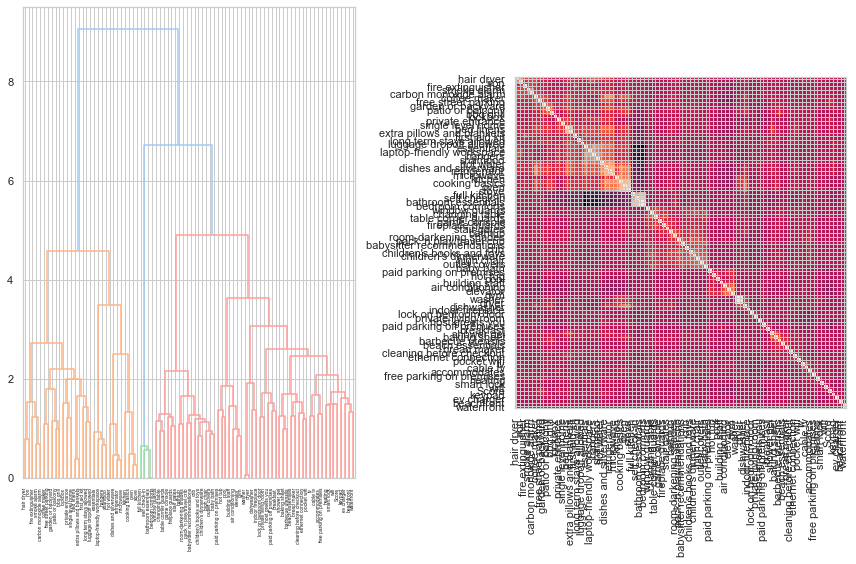

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_final).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=labelling.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

### After Removing

In [36]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [37]:
X_train_sel = X_train_oversample.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train_oversample)
print("Accuracy on test data with features removed: {}".format(clf_sel.score(X_test_sel, y_test)))

feature_selection_df['after feature extraction'] = [clf_sel.score(X_test_sel, y_test), len(X_train_sel.columns)]

Accuracy on test data with features removed: 0.6541105642110402


In [38]:
Filepath = "permutation_importance_features_removed.pickle"
if os.path.exists(Filepath):
    with open(Filepath, 'rb') as f:
        result_features_removed = pickle.load(f)
        print("read success!")
else:
    result_features_removed = permutation_importance(clf_sel, 
                                                        X_train_sel, 
                                                        y_train_oversample, 
                                                        n_repeats=10,
                                                        random_state=42)
    with open(Filepath, 'wb') as f:
        pickle.dump(result_features_removed, f, pickle.HIGHEST_PROTOCOL)

read success!


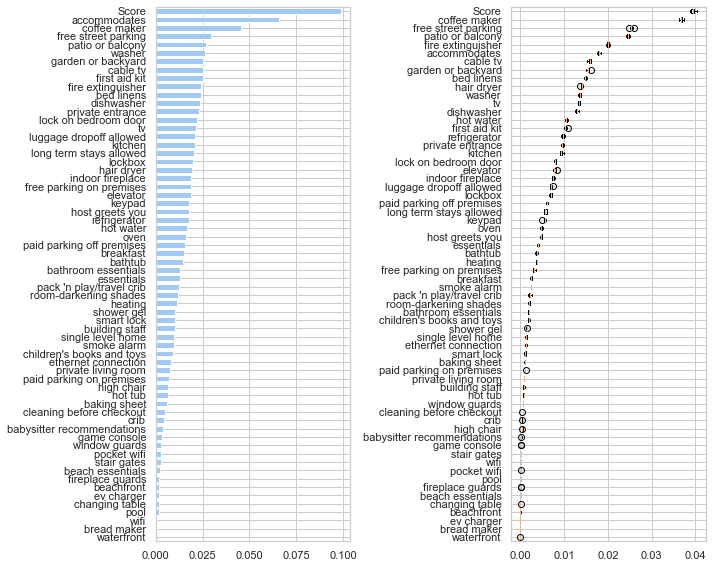

In [39]:
labelling2 = X_train_sel.columns
labelling2 = labelling2.to_numpy()

perm_sorted_idx2 = result_features_removed.importances_mean.argsort()

tree_importance_sorted_idx2 = np.argsort(clf_sel.feature_importances_)
tree_indices2 = np.arange(0, len(clf_sel.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.barh(tree_indices2,
         clf_sel.feature_importances_[tree_importance_sorted_idx2], height=0.7)
ax1.set_yticklabels(labelling2[tree_importance_sorted_idx2])
ax1.set_yticks(tree_indices2)
ax1.set_ylim((0, len(clf_sel.feature_importances_)))
ax2.boxplot(result_features_removed.importances[perm_sorted_idx2].T, vert=False,
            labels=labelling2[perm_sorted_idx2])
fig.tight_layout()
plt.show()

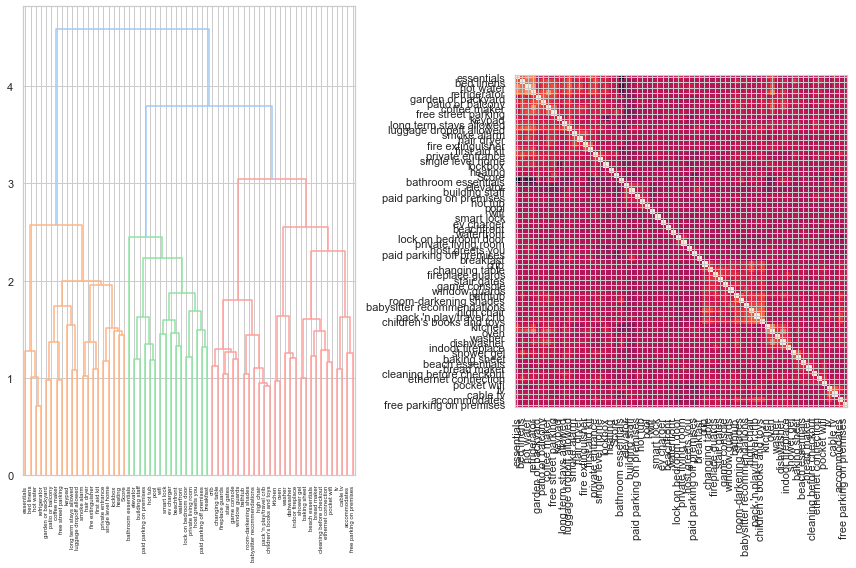

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_final.iloc[:, selected_features]).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=labelling2.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

### Comparing feature selection result

In [41]:
pd.DataFrame.from_dict(feature_selection_df)

,Result,before feature extraction,after feature extraction
0,Accuracy,0.654355,0.654111
1,Number of Features,86.000000,64.000000


#### Features removed

In [42]:
removed_list = []
for i in range(86):
    if not (i in selected_features):
        removed_list.append(i)

remove_item =  X_train_oversample.iloc[:, removed_list]
remove_item.columns

Index(['hangers', 'carbon monoxide alarm', 'iron', 'shampoo',
       'laptop-friendly workspace', 'dryer', 'microwave',
       'dishes and silverware', 'cooking basics', 'stove',
       'extra pillows and blankets', 'air conditioning', 'gym', 'bbq grill',
       'bedroom comforts', 'children's dinnerware', 'full kitchen',
       'self check-in', 'outlet covers', 'barbecue utensils', 'baby bath',
       'table corner guards'],
      dtype='object')

### Different attempt

In [48]:
from eli5.sklearn import PermutationImportance

In [50]:
clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train_oversample)
perm = PermutationImportance(clf_sel, n_iter=5, random_state=42)
eli5_model = perm.fit(X_train_sel, y_train_oversample) 
eli5.show_weights(eli5_model, feature_names=labelling2.tolist(), top=42)

In [53]:
Filepath = "eli5_model.pickle"
if os.path.exists(Filepath):
    with open(Filepath, 'rb') as f:
        eli5_model = pickle.load(f)
        print("read success!")
else:
    clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_sel.fit(X_train_sel, y_train_oversample)
    perm = PermutationImportance(clf_sel, n_iter=5, random_state=42)
    eli5_model = perm.fit(X_train_sel, y_train_oversample) 
    
    with open(Filepath, 'wb') as f:
        pickle.dump(result_features_removed, f, pickle.HIGHEST_PROTOCOL)

eli5.show_weights(eli5_model, feature_names=labelling2.tolist(), top=42)

Weight,Feature
0.0396 ± 0.0009,Score
0.0368 ± 0.0006,coffee maker
0.0255 ± 0.0003,free street parking
0.0243 ± 0.0005,patio or balcony
0.0202 ± 0.0006,fire extinguisher
0.0178 ± 0.0005,accommodates
0.0159 ± 0.0005,cable tv
0.0156 ± 0.0008,garden or backyard
0.0150 ± 0.0009,bed linens
0.0141 ± 0.0002,hair dryer


##  Modelling

From the resampling reuslt, we know that oversample technique gives the best result hence we will be using dataset from oversample.

### Default param

In [43]:
scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']

In [44]:
Filepath = "modelling_raw.pickle"
if os.path.exists(Filepath):
    models_initial = pd.read_pickle(Filepath)
    print("read success!")
else:
    models = [LogisticRegression(solver='liblinear'), DecisionTreeClassifier(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(),
             RandomForestClassifier(),KNeighborsClassifier(),GaussianNB()]

    scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
    fit_time = []
    score_time= []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    roc = []

    for model in models:
        scores = cross_validate(model, X_train_oversample.iloc[:, selected_features], y_train_oversample, scoring=scoring, cv=20)
        sorted(scores.keys())
        fit_time.append(scores['fit_time'].mean())
        score_time.append(scores['score_time'].mean())
        accuracy.append(scores['test_accuracy'].mean())
        precision.append(scores['test_precision_macro'].mean())
        recall.append(scores['test_recall_macro'].mean())
        f1.append(scores['test_f1_weighted'].mean())
        roc.append(scores['test_roc_auc'].mean())

    models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': fit_time,
    'Scoring time': score_time,
    'Accuracy'    : accuracy,
    'Precision'   : precision,
    'Recall'      : recall,
    'F1_score'    : f1,
    'AUC_ROC'     : roc,
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

    models_initial = models_initial.sort_values(by='Accuracy', ascending=False)
    models_initial.to_pickle(Filepath)

read success!


In [45]:
models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
4,Random Forest,42.605582,0.614610,0.684844,0.685402,0.684844,0.684608,0.757029
1,Decision Tree,2.692306,0.032924,0.684607,0.685312,0.684608,0.684308,0.756761
3,Quadratic Discriminant Analysis,0.936375,0.063230,0.603757,0.603866,0.603757,0.603654,0.637020
5,K-Nearest Neighbors,101.395182,75.320397,0.598587,0.605196,0.598588,0.592148,0.621602
0,Logistic Regression,2.683210,0.027353,0.598207,0.599190,0.598207,0.597209,0.639711
2,Linear Discriminant Analysis,2.503155,0.034109,0.598162,0.599187,0.598162,0.597121,0.639614
6,Bayes,0.399874,0.051145,0.580500,0.581063,0.580500,0.579766,0.612623


### Various param

In [46]:
Filepath = "modelling_Processed.pickle"
if os.path.exists(Filepath):
    models_initial2 = pd.read_pickle(Filepath)
    print("read success!")
else:
    models = [DecisionTreeClassifier(criterion = "entropy"), 
              RandomForestClassifier(n_estimators = 200,
                                     criterion = "entropy"),
              KNeighborsClassifier(n_neighbors=2)]

    scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
    fit_time = []
    score_time= []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    roc = []
    for model in models:
        scores = cross_validate(model, X_train_oversample.iloc[:, selected_features], y_train_oversample, scoring=scoring, cv=20)
        sorted(scores.keys())
        fit_time.append(scores['fit_time'].mean())
        score_time.append(scores['score_time'].mean())
        accuracy.append(scores['test_accuracy'].mean())
        precision.append(scores['test_precision_macro'].mean())
        recall.append(scores['test_recall_macro'].mean())
        f1.append(scores['test_f1_weighted'].mean())
        roc.append(scores['test_roc_auc'].mean())

    models_initial2 = pd.DataFrame({
    'Model'       : ['Decision Tree','Random Forest', 'K-Nearest Neighbors'],
    'Fitting time': fit_time,
    'Scoring time': score_time,
    'Accuracy'    : accuracy,
    'Precision'   : precision,
    'Recall'      : recall,
    'F1_score'    : f1,
    'AUC_ROC'     : roc,
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

    models_initial2 = models_initial2.sort_values(by='Accuracy', ascending=False)
    models_initial2.to_pickle(Filepath)

In [47]:
models_initial2

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
1,Random Forest,88.823269,1.277810,0.684964,0.685536,0.684964,0.684721,0.757093
0,Decision Tree,2.708636,0.031519,0.684615,0.685319,0.684615,0.684316,0.756788
2,K-Nearest Neighbors,99.498311,70.293340,0.579481,0.579819,0.579481,0.579042,0.597299
